##**GW170823 Characteristics:**

Nature: Black hole binary systemS.

Mass1: 39.6(+11.2,-6.7) $M_{\odot}%s$

Mass2: 29.3(+6.3,-7.8) $M_{\odot}%s$

Distance from Earth: 1950(+840,-840) Mpc

**Note**:

  Mpc = Megaparsecs

  $M_{\odot}%s$= Solar Mas

 1 solar mass = mass of our son

 1 Mpc = 3261563.7769443 Light years

In [1]:
import sys
!{sys.executable} -m pip install pycbc ligo-common --no-cache-dir
from pycbc.waveform import get_td_waveform
import pylab

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 52.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.2/201.2 kB 146.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 192.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 110.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 kB 118.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 185.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 141.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.1/43.1 MB 178.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 218.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting

/usr/local/lib/python3.10/dist-packages/pycbc/types/array.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(True)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal as _lal


# **Matched Filtering**

## **Illustraion on the model parameters can be found in GW150914-H1 jupyter notebook**

# **Filtering the data**



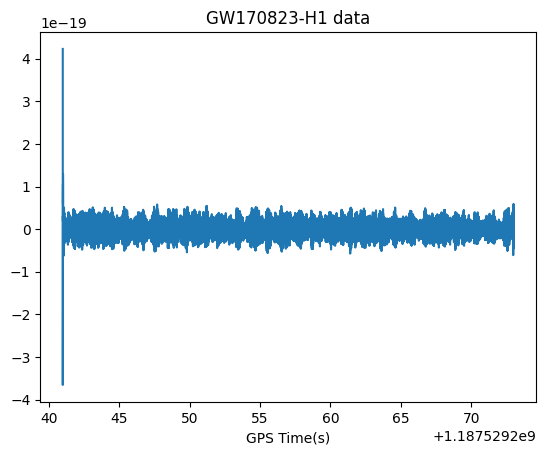

In [2]:
from pycbc.catalog import Merger
from pycbc.filter import resample_to_delta_t, highpass

merger_system = Merger("GW170823")

# Get the data from the Hanford detector
strain_data = merger_system.strain('H1')

# Remove the low frequency content and downsample the data to 2048Hz
strain_data = resample_to_delta_t(highpass(strain_data, 15.0), 1.0/2048)

pylab.plot(strain_data.sample_times, strain_data)
pylab.xlabel('GPS Time(s)')
pylab.title('GW170823-H1 data')
pylab.show()


# GW170823
# GW151226

#### filter wraparound

due to highpass filtering and resampling, spikes at the boundaries of our data have been generated. To avoid this we trim the ends of the data sufficiently to ensure that they do not wraparound the input. We will enforce this requirement in all steps of our filtering, and this shall have no impact on the accuracy of our model.

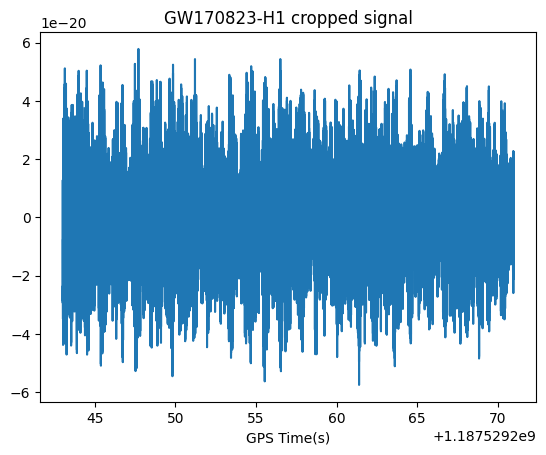

In [3]:
# Remove 2 seconds of data from both the beginning and end
cropped = strain_data.crop(2, 2)

pylab.plot(cropped.sample_times, cropped)
pylab.xlabel('GPS Time(s)')
pylab.title('GW170823-H1 cropped signal')
pylab.show()

#### calculate the power spectral density

Optimal matched filtering requires weighting the frequency components of the potential signal and data by the noise amplitude. We can view this as filtering the data with the time series equivelant of 1 / PSD. To ensure that we can control how much applying this filter to the data, we window the time domain equivelant of the PSD to a specific length.

(30, 1024)

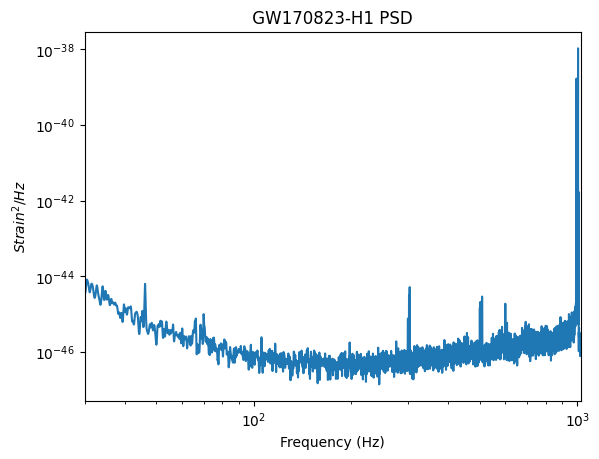

In [4]:
from pycbc.psd import interpolate, inverse_spectrum_truncation
# Estimate the power spectral density
# We use 4 second samples.
psd = cropped.psd(4)

# interpolate the PSD to match our data
# and then limit the filter length of 1 / PSD. After this, we can
# directly use this PSD to filter the data in a controlled manner

psd = interpolate(psd, cropped.delta_f)

# 1/PSD will now act as a filter with an effective length of 4 seconds
psd = inverse_spectrum_truncation(psd, int(4 * cropped.sample_rate),
                                  low_frequency_cutoff=15) # the cutoff is to avoid low values as we highpassed the data before at threshold 15Hz

pylab.loglog(psd.sample_frequencies, psd)
pylab.ylabel('$Strain^2 / Hz$')
pylab.title(' GW170823-H1 PSD ')
pylab.xlabel('Frequency (Hz)')
pylab.xlim(30, 1024)

#**Creating the simulated signal**

In general, matched filtering involves laying the potential signal over your data and integrating (after weighting frequencies correctly). If there is a signal in the data that aligns with your 'simulated', you will get a large value when integrated over.

Since we already know our merger system, we then have the key parameters discussed above, and we'll use them now to build the model to simulate similar conditions to our system.

**Note**: since the masses the two compononets in the binary systems overlaps in the range of uncertainties we will be assuming equaly masses for both bodies. If this have shown some in accuracies we will adjust it, but in principal it shouldn't

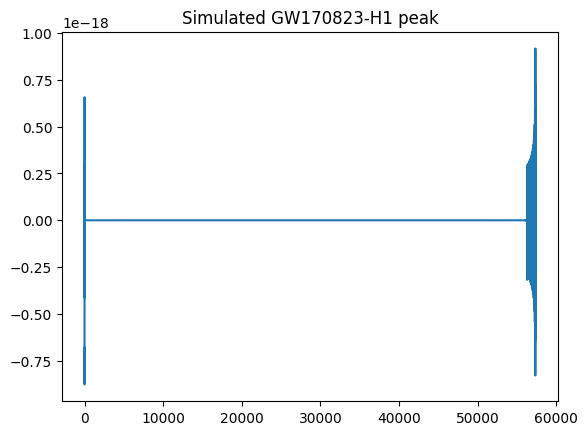

In [5]:
m = 39 # Solar masses
hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
                     mass1=m,
                     mass2=m,
                     delta_t=cropped.delta_t,
                     f_lower=20)

#  resize to match our data
hp.resize(len(cropped))

# The waveform begins at the start of the vector, so if we want the
# SNR time series to correspond to the approximate merger location
# we need to shift the data so that the merger is approximately at the
# first bin of the data.

# This function rotates the vector by a fixed amount of time.
# Note that time stamps are not affected, but the true
# position in the vector is.

# In our simulation we will be taking the plus polarization into account and see how accurate the results will be.
simulated = hp.cyclic_time_shift(hp.start_time)
pylab.plot(simulated)
pylab.title('Simulated GW170823-H1 peak')
pylab.show()

#### calculating the signal-to-noise time series

In this section we will calculate the signal-to-noise time series for our simulated.

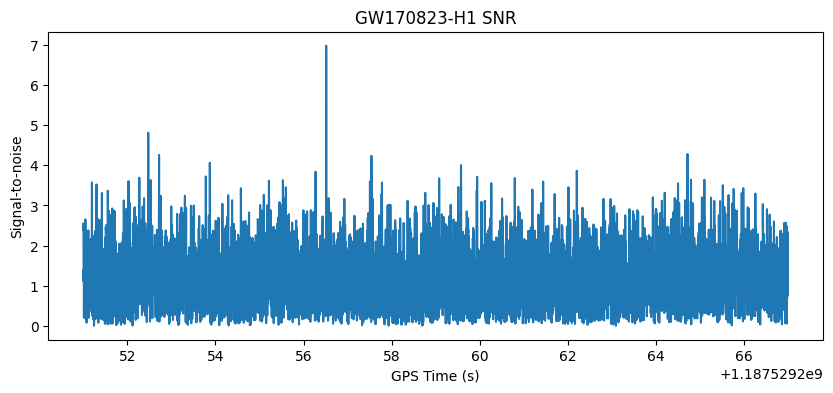

We found a signal at 1187529256.5141602s GPS Timing with SNR 6.980040561322267


In [6]:
from pycbc.filter import matched_filter
import numpy

snr = matched_filter(simulated, cropped,
                     psd=psd, low_frequency_cutoff=20)


# remove 4 seconds at the beginning and 4 seconds at the end to eliminate time corrupted by the simulated filter and psd filter:
snr = snr.crop(4 + 4, 4)
# plot the results:
pylab.figure(figsize=[10, 4])
pylab.plot(snr.sample_times, abs(snr)) # since the Matched filter returns complex number, we will take their real part to maximize over the phase signal
pylab.ylabel('Signal-to-noise')
pylab.title('GW170823-H1 SNR')
pylab.xlabel('GPS Time (s)')
pylab.show()

# EXTRACT THE CHIRPING PEAK OF THE SIMULATED SIGNAL AND ITS TIME OF OCCURENCE
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]

print("We found a signal at {}s GPS Timing with SNR {}".format(time,
                                                    abs(snrp)))  # THIS WILL CORRESPOND TO THE CHIRPING PEAK

# **Aligning and Subtracting the Proposed Signal**


After getrting our simulated chirping peak, we will use it to align our simulation to the original data of GW170823.

In [7]:
from pycbc.filter import sigma

# Shift our simulation to the time of the Chirping peak
dt = time - cropped.start_time
cohered = simulated.cyclic_time_shift(dt)

# scale the simulation to get SNR= 1 in this data
cohered /= sigma(cohered, psd=psd, low_frequency_cutoff=20.0)

# Scale the simulated amplitude and phase to the peak value
cohered = (cohered.to_frequencyseries() * snrp).to_timeseries()
cohered.start_time = cropped.start_time

#### **Overlap plot of the similation and the original data**

As we did in our analysis of the GW190817 and GW170817 systems, we will whiten both, the simulated signal and the original data, to highlight noise and then bandpass them to get the relavent frequency range that is contributing to the merger event only(30-300Hz).

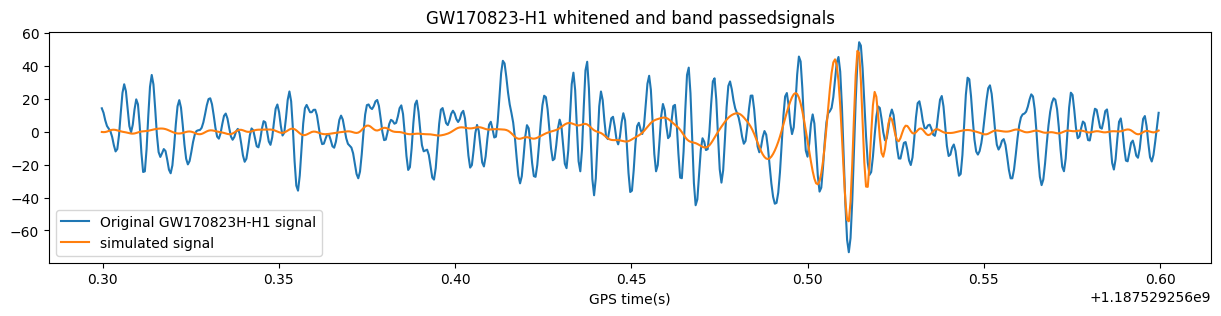

In [8]:
# whiten and band pass the data and simulation:
white_data = (cropped.to_frequencyseries() / psd**0.5).to_timeseries() # whiten the original data

# whiten the simulated signal
tapered = cohered.highpass_fir(30, 512, remove_corrupted=False)
white_simulated = (tapered.to_frequencyseries() / psd**0.5).to_timeseries()

white_data = white_data.highpass_fir(30., 512).lowpass_fir(300, 512) # bandpas original data
white_simulated = white_simulated.highpass_fir(30, 512).lowpass_fir(300, 512)  # band pass simulated data

# Select the time around the merger
white_data = white_data.time_slice(merger_system.time-.2, merger_system.time+.1) # whiten original data
white_simulated = white_simulated.time_slice(merger_system.time-.2, merger_system.time+.1) # whiten simulated data

pylab.figure(figsize=[15, 3])
pylab.plot(white_data.sample_times, white_data, label="Original GW170823H-H1 signal")
pylab.plot(white_simulated.sample_times, white_simulated, label="simulated signal")
pylab.title('GW170823-H1 whitened and band passedsignals')
pylab.xlabel('GPS time(s)')
pylab.legend()
pylab.show()

Notice that a considerable alignment between our simulation and the original data can bee seen at the time of the merger, and all that is left now is to extract our signal by subtracting the simulated chirping peak from the original data.

#### **Subtracting the signal from the data and spctrogram**

We will plot both the spectrogram of the original data before and after the  subtraction by our simulated signal to see how accurate our simulation is.

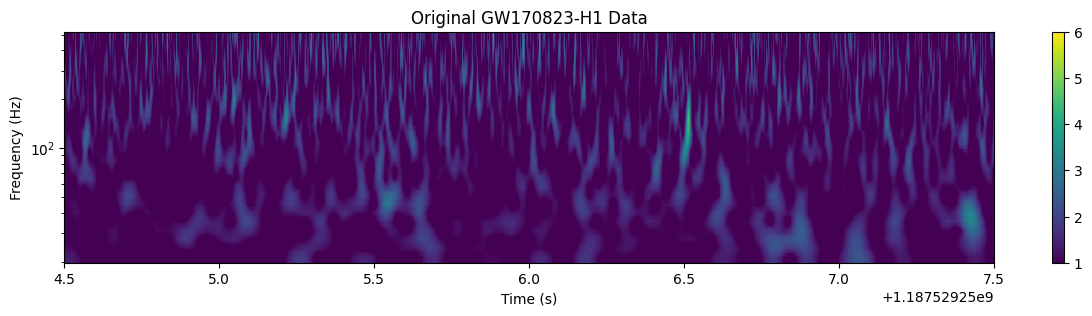

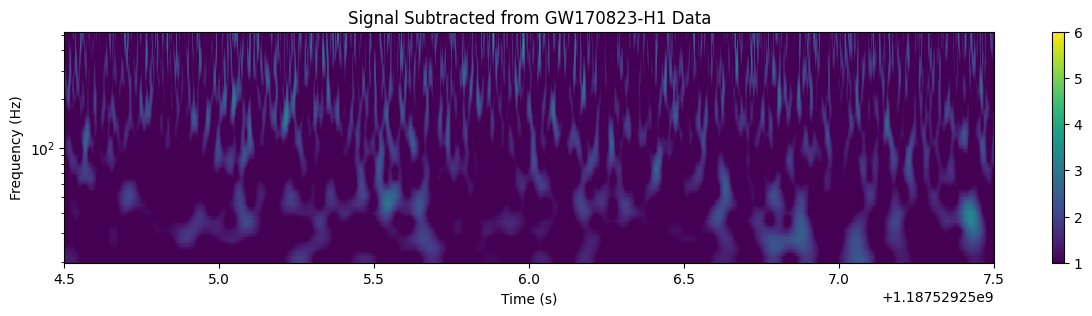

In [9]:
subtracted = cropped - cohered
# sim_chirping= cropped - subtracted
# Plot the original data and the subtracted signal data

for data, title in [(cropped, 'Original GW170823-H1 Data'),
                    (subtracted, 'Signal Subtracted from GW170823-H1 Data')]:

    t, f, p = data.whiten(4, 4).qtransform(.001,
                                                  logfsteps=100,
                                                  qrange=(8, 8),
                                                  frange=(20, 512))
    pylab.figure(figsize=[15, 3])
    pylab.title(title)
    pylab.pcolormesh(t, f, p**0.5, vmin=1, vmax=6)
    pylab.colorbar()
    pylab.yscale('log')
    pylab.xlabel('Time (s)')
    pylab.ylabel('Frequency (Hz)')
    pylab.xlim(merger_system.time - 2, merger_system.time + 1)
    pylab.show()